In [1]:
from ae import VAE
import torch
vae = VAE(
    resolution=256,
    in_channels=3,
    ch=256,
    out_ch=3,
    ch_mult=[1, 2, 4, 4],
    num_res_blocks=2,
    z_channels=16,
)
state_dict = torch.load("/home/ubuntu/auravasa/ckpt/exp_vae_ch_256_lr_0.0078125_singlechannel_l1_gan/vae_epoch_1_step_49501.pt")

/tmp/ipykernel_1560312/1324862723.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/home/ubuntu/auravasa/ckpt/exp_vae_ch_256_lr_0.0078125_single

In [2]:
new_state_dict = {
    k.replace("module.", ""): v for k, v in state_dict.items()
}
vae.load_state_dict(new_state_dict)

<All keys matched successfully>

In [28]:
vae.eval().cuda()
from torchvision import transforms
imgpath = 'contents/randomwoman.jpeg'
imgpath = 'contents/lavender.jpg'
from PIL import Image
img_orig = Image.open(imgpath).convert("RGB")
offset = 128
W = 768
img_orig = img_orig.crop((offset, offset, W + offset, W + offset))
img = transforms.ToTensor()(img_orig).unsqueeze(0).cuda()
img = (img - 0.5) / 0.5

with torch.no_grad():
    z = vae.encoder(img)
    print(z.shape)
    

torch.Size([1, 16, 96, 96])


In [30]:
# z distribution
z = z.cpu().reshape(-1)
print(f"z.min(): {z.min():.2f}, z.max(): {z.max():.2f}, 20 %: {z.quantile(0.2):.2f}, 40 %: {z.quantile(0.4):.2f}, 60 %: {z.quantile(0.6):.2f}, 80 %: {z.quantile(0.8):.2f}")

z.min(): -27.68, z.max(): 29.31, 20 %: -1.84, 40 %: -0.32, 60 %: 0.84, 80 %: 2.33


In [22]:
# count param size.
total_params = sum(p.numel() for p in vae.parameters())
print(f"Total parameters: {total_params/1000**2:.1f}M")


Total parameters: 334.5M


0.0 82.0
0.0 89.0
0.0 87.0
0.0 83.0
0.0 79.0
0.0 101.0
0.0 84.0
0.0 116.0
0.0 115.0
0.0 119.0
0.0 133.0


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1536, 808) to (1536, 816) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


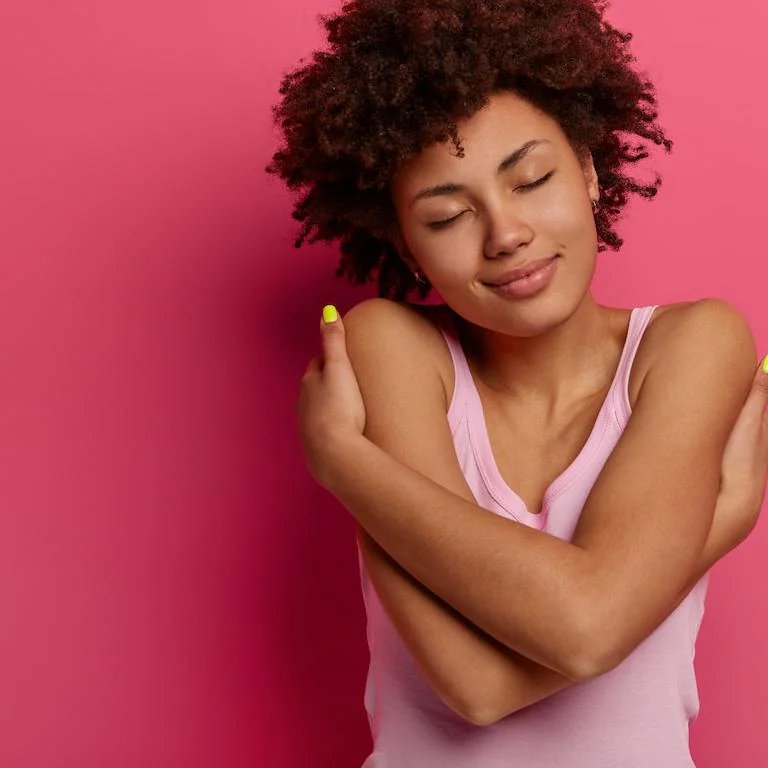

In [26]:
# back to image
noise_level_images = []

img_orig = img_orig.resize((W, W))

from PIL import ImageDraw, ImageFont
import numpy as np


for noise_level in range(0, 11):
    noise_level = noise_level / 20
    with torch.no_grad():
        decz = vae.decoder(z * (1 + noise_level * torch.randn_like(z)))
    decimg = (decz + 1) / 2
    decimg = decimg.clamp(0, 1).squeeze(0).cpu().numpy().transpose(1, 2, 0)
    decimg = (decimg * 255).astype('uint8')
    decimg = Image.fromarray(decimg)
    
    decimg = decimg.resize((W, W))
    
    # put noise level on the image
    newimg = Image.new("RGB", (decimg.width * 2, decimg.height + 40), (255, 255, 255))
    #newimg.paste(img_orig, (0, 40))
    newimg.paste(decimg, (0, 40))
    
    diffimag = ((np.array(img_orig).astype('float32') - np.array(decimg).astype('float32')))
    diffimag = abs(diffimag)
    print(diffimag.min(), diffimag.max())
    diffimag = diffimag.astype('uint8')
    
    diffimag = Image.fromarray(diffimag)
    newimg.paste(diffimag, (decimg.width, 40))
    draw = ImageDraw.Draw(newimg)
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
    draw.text((10, 10), f"Noise level: {100 * noise_level:.0f}%", fill=(0, 0, 0), font=font)
    noise_level_images.append(newimg)
    
# make a mp4
import imageio
imageio.mimsave('noise_level_images.mp4', noise_level_images, fps=5)

img_orig

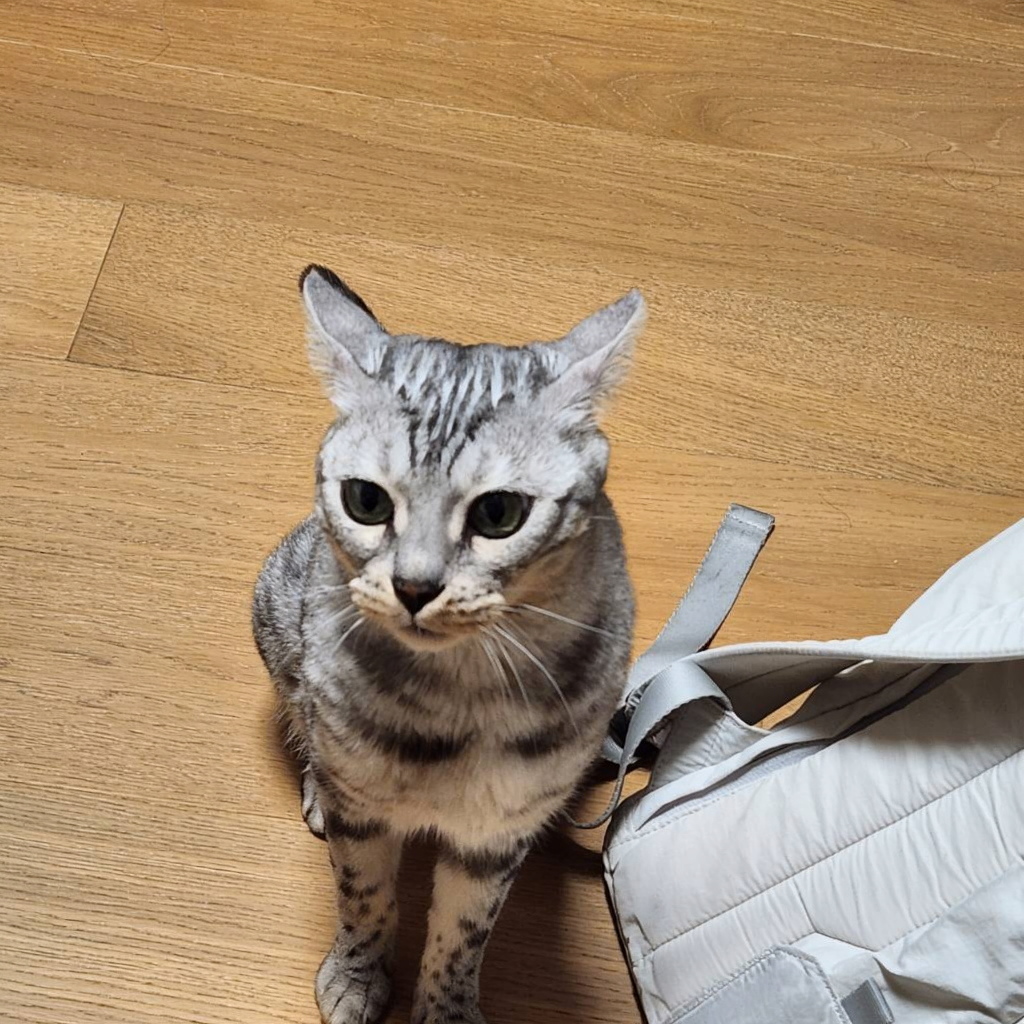

In [23]:
decimg